<img src="https://raw.githubusercontent.com/AndresGuarin/MisMateriales/main/Images/IronProtonXmaxDetection.jpg"  width="1000px" height="400px">


# <center> **Detección del Número Máximo de Partículas de una Cascada de Astropartículas** </center>

## **Outline**
1. [**Reading data**](#eje1)
2. [**Model**](#eje2)
3. [**Evaluating other dataset and methods**](#eje3)
4. [**Learning curves**](#eje4)

In [ ]:
#@title **MONTAR EL DRIVE** { display-mode: "form" }
import os
from google.colab import drive

path_ai = "IA-1/Proyecto" #@param {type:"string"}
path = "/content/drive/My Drive/" + path_ai
drive.mount('/content/drive')
os.chdir(path)
print(os.getcwd())

In [ ]:
#@title **Load libs** { display-mode: "form" }
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
pd.__version__
from sklearn.model_selection import KFold
from sklearn.metrics import *

#1. **Reading data** <a name="eje1"></a>

In [ ]:
# Iron data
iron = pd.read_csv('data/CutEvents_IronRefDist140.txt',skiprows=2,sep='\t',decimal='.')  #sep='\t' is for tab separator

for col in iron.columns[58:]:  # For cleaning colums of Nans
  del iron[col]
iron.rename(columns = {'M beta syst100000':'M beta syst'}, inplace = True)

# Proton data
proton = pd.read_csv('data/CutEvents_ProtonRefDist140.txt',sep='\t',decimal='.')

# Concating data
data = pd.concat([iron,proton])

# Cleaning data
col = data.pop("MC Xmax") # For put the target column 'MC Xmax' at the end of dataframe
data.insert(len(data.columns), col.name, col)

for col in ['runnr', 'rad energy error', '2dLDF sigma error','EE_RdLDF1error','EE_RdLDF3error','EE_RdLDF2error',
            'GeoCe DXmax Error','GeoCe Erad Error', 'N_mu_ref error','M beta error']:  # For errasing unrelevant columns
  del data[col]
data

,MC energy,MC zenith,MC azimuth,MC core x,MC core y,MC core z,Sd rec success,Sd energy,SD zenith,SD azimuth,...,GeoCe LDF ndf,pvalue GeoCe,Md rec success,N_mu_ref,MLDF Chi2,MLDF NDF,MLDF Likelihood,M beta,M beta syst,MC Xmax
0,1.549610e+18,41.0088,303.544,449498,6113960.0,1468.23,1,1.158430e+18,40.7990,303.8270,...,2,5.522280e-01,1,2.375530,42.65270,42,26.63010,1.109980,0,641.545
1,2.535990e+17,34.4273,204.927,450569,6114990.0,1468.11,1,2.077700e+17,33.5715,204.8110,...,1,5.848000e-01,1,0.603343,11.23330,12,7.14209,1.084460,0,586.647
2,2.557910e+17,41.8761,291.040,449957,6114220.0,1468.64,1,1.495360e+17,41.4153,289.9990,...,2,9.316390e-01,1,0.460631,9.15930,12,5.93662,1.714770,0,556.775
3,1.478830e+18,48.8578,163.620,450725,6114750.0,1466.90,1,1.204640e+18,48.5606,163.8390,...,18,6.242530e-10,1,2.482500,60.65770,49,38.28580,1.115640,0,651.333
4,7.992670e+17,47.9999,20.302,448781,6114250.0,1478.29,1,6.018360e+17,48.3129,20.4129,...,3,5.236580e-01,1,1.531090,21.60800,24,13.32660,0.947208,0,660.695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2137,2.830380e+17,42.1923,299.907,450837,6114940.0,1464.25,1,2.847940e+17,41.5514,297.6510,...,9,2.281540e-14,1,0.673622,16.09300,13,10.76710,0.726538,0,716.003
2138,7.031340e+16,31.5730,313.950,451208,6114290.0,1459.11,1,7.495520e+16,33.6773,313.9710,...,5,3.836610e-02,1,0.197141,4.87348,6,4.92578,1.598330,0,621.258
2139,2.081160e+18,31.6012,100.132,450405,6114330.0,1466.43,1,1.727270e+18,32.1312,99.8235,...,1,2.387730e-02,1,2.475100,63.56010,45,36.74840,1.540620,0,741.709
2140,3.655930e+17,54.1971,240.092,450736,6114530.0,1463.18,1,2.899870e+17,53.4601,240.9910,...,18,2.917480e-06,1,0.375106,10.20190,9,8.00254,0.570119,0,690.726


#1. **Model** <a name="eje2"></a>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

print(data.shape)

X = data.values[:,:-1]
y = data.values[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
est = DecisionTreeRegressor()
est.fit(X_train,y_train)
s = np.sqrt(mean_squared_error(y_test, est.predict(X_test)))
features = est.feature_importances_

print(s)

best_features = np.sort(features)
index = []
for best in best_features:
  index.append(list(features).index(best))
data.columns[index]

(4465, 48)
56.16397278749631


Index(['Sd rec success', 'Sd rec success', 'Sd rec success', 'Sd rec success',
       '2dLDf NDF', 'EE_RdLDFNDF', 'GeoCe LDF ndf', 'Rd azimuth',
       'Stations with Pulse', 'SD core z', 'SD azimuth', 'Rd core x',
       'pvalue1dLDF', 'MC core y', 'rad energy', 'lorentz angle', '2dLDF Chi2',
       'Rd zenith', 'EE_RdLDF1', 'Rd energy', 'MC core z', 'MC core x',
       'SD core x', 'GeoCe LDFChi2', 'MLDF Likelihood', 'Rd core z',
       'SD core y', 'MLDF Chi2', 'Rd core y', 'OnedLDFChi2', 'EE_RdLDF2',
       'MC azimuth', 'MLDF NDF', 'SD zenith', 'GeoCe DXmax', 'SE_RdLDF1',
       'GeoCe Erad', 'EE_RdLDF3', 'MC zenith', 'SE_RdLDF2', 'M beta',
       'Sd energy', 'MC energy', 'pvalue GeoCe', 'N_mu_ref', '2dLDF sigma',
       'GeoCeXmax'],
      dtype='object')

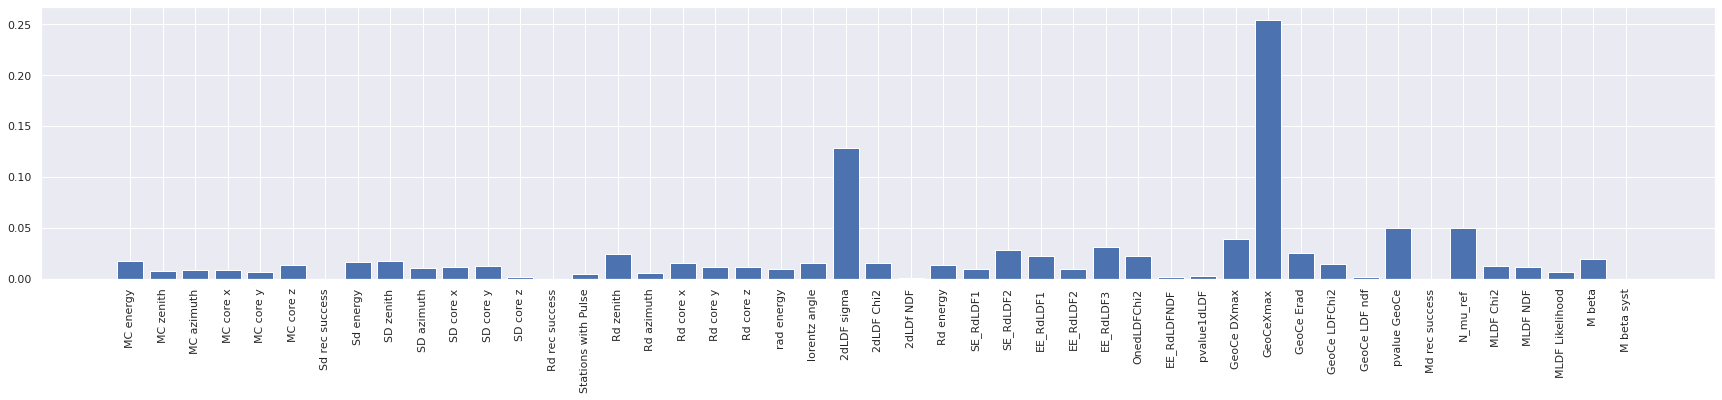

In [ ]:
f = plt.figure(figsize=(30,5))
f.subplots_adjust(wspace=0.5)
ax = f.add_subplot(111)
plt.bar(range(len(features)),features)
plt.xticks(range(len(features)),data.columns[:-1],rotation='vertical')
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.131186 to fit


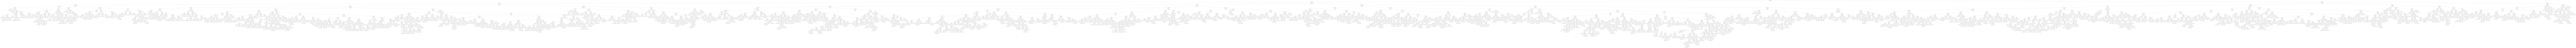

In [ ]:
#@title **code** Visualize the resultant tree
#!sudo apt-get install graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image

export_graphviz(est, out_file='tree_r.dot', feature_names=data.columns[:-1])
!dot -Tpng tree_r.dot > tree_r.png

Image(filename='tree_r.png') 

## **Pruebas**

In [ ]:
particles.columns

Index(['runnr', 'MC energy', 'MC zenith', 'MC azimuth', 'MC core x',
       'MC core y', 'MC core z', 'Sd rec success', 'Sd energy', 'SD zenith',
       'SD azimuth', 'SD core x', 'SD core y', 'SD core z', 'Rd rec success',
       'Stations with Pulse', 'Rd zenith', 'Rd azimuth', 'Rd core x',
       'Rd core y', 'Rd core z', 'rad energy', 'rad energy error',
       'lorentz angle', '2dLDF sigma', '2dLDF sigma error', '2dLDF Chi2',
       '2dLDf NDF', 'Rd energy', 'SE_RdLDF1', 'SE_RdLDF2', 'EE_RdLDF1',
       'EE_RdLDF1error', 'EE_RdLDF2', 'EE_RdLDF2error', 'EE_RdLDF3',
       'EE_RdLDF3error', 'OnedLDFChi2', 'EE_RdLDFNDF', 'pvalue1dLDF',
       'GeoCe DXmax', 'GeoCeXmax', 'GeoCe DXmax Error', 'GeoCe Erad',
       'GeoCe Erad Error', 'GeoCe LDFChi2', 'GeoCe LDF ndf', 'pvalue GeoCe',
       'Md rec success', 'N_mu_ref', 'N_mu_ref error', 'MLDF Chi2', 'MLDF NDF',
       'MLDF Likelihood', 'M beta', 'M beta error', 'M beta syst', 'MC Xmax'],
      dtype='object')

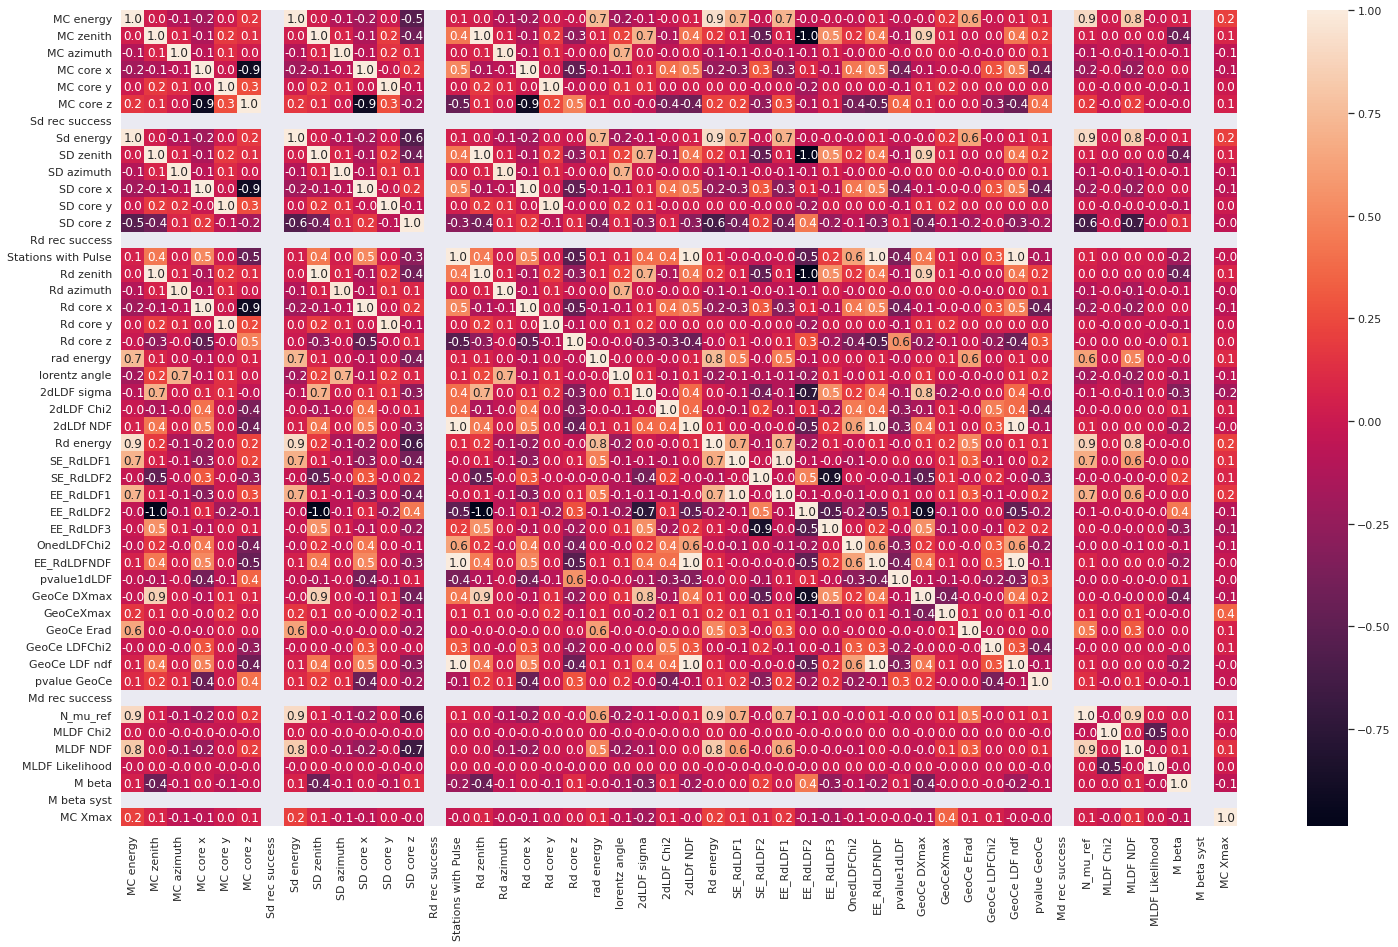

In [ ]:
plt.subplots(figsize=(25,15)) 
corr = particles.corr()
sns.heatmap(corr, annot=True, fmt=".1f")
plt.show()

In [ ]:
#display(particles['MC Xmax'])
#particles['GeoCeXmax']
print('MC Xmax Iron:    %.4f +/- %.4f'%(np.mean(iron['MC Xmax'].values), np.std(iron['MC Xmax'].values)))
print('GeoCeXmax Iron:  %.4f +/- %.4f'%(np.mean(iron['GeoCeXmax'].values), np.std(iron['GeoCeXmax'].values)))
print()
print('MC Xmax Proton:    %.4f +/- %.4f'%(np.mean(proton['MC Xmax'].values), np.std(proton['MC Xmax'].values)))
print('GeoCeXmax Proton:  %.4f +/- %.4f'%(np.mean(proton['GeoCeXmax'].values), np.std(proton['GeoCeXmax'].values)))

MC Xmax Iron:    622.7639 +/- 30.5248
GeoCeXmax Iron:  638.0860 +/- 94.3897

MC Xmax Proton:    706.0959 +/- 47.8885
GeoCeXmax Proton:  683.4042 +/- 87.8247


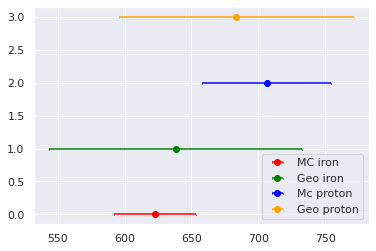

In [ ]:
x = [np.mean(iron['MC Xmax'].values), np.mean(iron['GeoCeXmax'].values), np.mean(proton['MC Xmax'].values),np.mean(proton['GeoCeXmax'].values)]
y = range(4)
dx = [np.std(iron['MC Xmax'].values), np.std(iron['GeoCeXmax'].values), np.std(proton['MC Xmax'].values),np.std(proton['GeoCeXmax'].values)]
color = ['red','green','blue','orange']
label = ['MC iron','Geo iron','Mc proton','Geo proton']
for i in range(4):
  plt.errorbar(x[i],y[i],fmt='o',xerr=dx[i],color=color[i], label=label[i],capsize=0.5)
plt.legend()
plt.show()